In [1]:
# ==============================================================================
# CELLA 0: SETUP TOTALE (MINIMAL & STABILE)
# ==============================================================================
import sys
import os
from IPython.display import clear_output

# 1. BLOCCO MODULI PROBLEMATICI
sys.modules["vllm"] = None
sys.modules["vllm.sampling_params"] = None

print("⏳ Setup Ambiente in corso... (Attendere, output nascosto)")

# 2. INSTALLAZIONE & AGGIORNAMENTO SILENZIOSO
# Scarica l'ultima versione di Unsloth da Git e aggiorna automaticamente 
# PyTorch e Transformers alle versioni più recenti e compatibili.
!pip install --upgrade --no-cache-dir --quiet \
    "torch" "torchvision" "torchaudio" \
    "transformers" "trl" "peft" "accelerate" "bitsandbytes" \
    "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git" \
    "unsloth_zoo @ git+https://github.com/unslothai/unsloth-zoo.git" \
    "pillow" "scikit-learn" "pandas"

# 3. VERIFICA E PULIZIA
clear_output()

import torch
import unsloth
import transformers
from PIL import Image

print(f"✅ Ambiente Pronto e Pulito.")
print(f"   • GPU: {torch.cuda.get_device_name(0)}")
print(f"   • PyTorch: {torch.__version__}")
print(f"   • Unsloth: {unsloth.__version__}")
print(f"   • Transformers: {transformers.__version__}")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/opt/conda/lib/python3.11/site-packages/pandas/core/computation/expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Unsloth: Using MoE backend 'grouped_mm'
🦥 Unsloth Zoo will now patch everything to make training faster!
✅ Ambiente Pronto e Pulito.
   • GPU: Tesla V100S-PCIE-32GB
   • PyTorch: 2.10.0+cu128
   • Unsloth: 2026.2.1
   • Transformers: 4.57.6


In [2]:
# ==============================================================================
# CELLA 1: SETUP AMBIENTE, IMPORT & PATHS
# ==============================================================================
import sys
import os
import gc
import json
import time
import re
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from datasets import load_from_disk
from unsloth import FastVisionModel
from IPython.display import clear_output

# Setup Display Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.4f}'.format)

# Installazione dipendenze
print("⏳ Verifica e installazione librerie...")
try:
    import unsloth
    from qwen_vl_utils import process_vision_info 
    import seaborn as sns
except ImportError:
    !pip install --upgrade --no-cache-dir --quiet "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git" "scikit-learn" "pandas" "unsloth_zoo" "qwen-vl-utils" "seaborn"
    from qwen_vl_utils import process_vision_info
    import seaborn as sns

print(f"✅ Setup completato. GPU: {torch.cuda.get_device_name(0)}")

⏳ Verifica e installazione librerie...
✅ Setup completato. GPU: Tesla V100S-PCIE-32GB


In [9]:
# ==============================================================================
# CELLA 2: CONFIGURAZIONE & GESTIONE CARTELLE OUTPUT
# ==============================================================================
# --- 1. Identità dell'Esperimento ---
# DEFINISCI QUI IL TIPO DI TEST (N1, N2, N3)
TEST_ID = "TEST_N1_M1_BINARY"  
# NOME DEL MODELLO (Per la sottocartella)
MODEL_SHORTNAME = "Qwen2.5-VL-M1-Detection" 

# Lista Seed
SEEDS_TO_TEST = [101, 285, 3692, 92]

# --- 2. Creazione Cartella Output Dinamica ---
# Struttura: TEST_EXPERIMENTS / <TEST_ID> / <MODEL_NAME>
BASE_ROOT = "TEST_EXPERIMENTS"
CURRENT_OUTPUT_DIR = os.path.join(BASE_ROOT, TEST_ID, MODEL_SHORTNAME)

os.makedirs(CURRENT_OUTPUT_DIR, exist_ok=True)

print(f"📂 I risultati finiranno in: {CURRENT_OUTPUT_DIR}")

# --- 3. Percorsi Input ---
# Dataset HF (M1 Detection)
DATASET_TEST_PATH = os.path.join("DATASET_ITA", "PROCESSED_DATA", "HF_DATASETS", "M1_detection") 
# Dove cercare gli adapter trainati
TRAIN_OUTPUTS_ROOT = "outputs" 

# --- 4. Parametri Inferenza ---
# M1 è binario: 0=Safe, 1=Offensive
TARGET_CLASSES = ["0", "1"] 
MODEL_ID_BASE = "unsloth/Qwen2.5-VL-7B-Instruct-bnb-4bit"
MAX_NEW_TOKENS = 8          
TEMPERATURE = 0.0 # Determinismo assoluto

# --- 5. SYSTEM PROMPT (M1 - BINARIO) ---
SYSTEM_INSTRUCTION_M1 = """Sei un classificatore binario esperto per la moderazione di contenuti social.
Valuta CONGIUNTAMENTE il commento testuale e i frame del video associato.

Il tuo compito è stabilire OGGETTIVAMENTE se è presente contenuto offensivo riconducibile ad una di queste categorie:
- Flaming: insulti, linguaggio aggressivo, minacce, parolacce dirette a una persona o gruppo.
- Denigration: umiliazione, disprezzo, svalutazione o ridicolizzazione di una persona o gruppo.
- Sexual: molestie, allusioni o offese a sfondo sessuale, oggettivazione o inviti espliciti.
- Racism: stereotipi, offese o discriminazione verso etnia, razza, cultura o nazionalità.

Regola decisionale:
- Rispondi 1 se rilevi contenuto offensivo riconducibile alle categorie sopra indicate.
- Rispondi 0 se il contenuto è neutro, positivo, o se si tratta di critica costruttiva/ironia non offensiva.

Linee guida:
- Basati solo sull'evidenza presente nei dati (testo + immagini).
- Non essere né troppo severo né troppo permissivo: attieniti alle definizioni.

Formato di output (OBBLIGATORIO):
Rispondi esclusivamente con un singolo carattere: 1 oppure 0.
Non aggiungere spiegazioni, punteggiatura o altro testo."""

print(f"⚙️ Configurazione Caricata: {TEST_ID} su {len(SEEDS_TO_TEST)} Seeds.")

📂 I risultati finiranno in: TEST_EXPERIMENTS/TEST_N1_M1_BINARY/Qwen2.5-VL-M1-Detection
⚙️ Configurazione Caricata: TEST_N1_M1_BINARY su 4 Seeds.


In [10]:
# ==============================================================================
# CELLA 3: CARICAMENTO DATASET & HELPER FUNCTIONS
# ==============================================================================
print("📂 Caricamento Test Set...")
try:
    dataset_raw = load_from_disk(DATASET_TEST_PATH)
    # Fallback intelligente per split name
    test_dataset = dataset_raw["test"] if "test" in dataset_raw else dataset_raw["val"]
    print(f"✅ Dataset caricato: {len(test_dataset)} campioni.")
except Exception as e:
    print(f"❌ Errore critico: {e}")
    raise e

def normalize_ground_truth(raw_label):
    """
    Normalizza le etichette per M1 (Binary).
    Mappa: '0', 'none' -> '0'
    Mappa: '1', '4', 'racism', 'sexual' -> '1'
    """
    s = str(raw_label).strip().lower()
    safe_labels = ["0", "none", "non-offensive", "neutral", "safe"]
    
    if s in safe_labels:
        return "0"
    else:
        return "1"

def build_input_for_inference(sample):
    """
    Costruisce l'input per il modello garantendo coerenza col training.
    Ignora il system prompt su disco e inietta quello fresco.
    """
    user_content_raw = None
    true_label_raw = None

    for msg in sample["messages"]:
        if msg["role"] == "user":
            user_content_raw = msg["content"]
        elif msg["role"] == "assistant":
            true_label_raw = msg["content"][0]["text"].strip()

    if not user_content_raw: return None, None, None

    # Normalizzazione Label
    true_label = normalize_ground_truth(true_label_raw)

    # Ricostruzione User Content
    final_user_content = []
    text_snippet = ""
    
    for item in user_content_raw:
        if item["type"] == "image":
            raw_path = item["image"]
            clean_path = raw_path.replace("file://", "")
            clean_path = "/" + clean_path.lstrip("/")
            if not os.path.exists(clean_path):
                return None, None, None 
            final_user_content.append({"type": "image", "image": f"file://{clean_path}"})

        elif item["type"] == "text":
            # Pulizia Idempotente
            text_nude = item["text"].replace("Commento:", "").strip().strip('"').strip("'")
            text_snippet = text_nude
            text_formatted = f"Commento: \"{text_nude}\""
            final_user_content.append({"type": "text", "text": text_formatted})

    prompt_msgs = [
        {"role": "system", "content": [{"type": "text", "text": SYSTEM_INSTRUCTION_M1}]},
        {"role": "user", "content": final_user_content}
    ]

    return prompt_msgs, true_label, text_snippet

def parse_prediction(pred_text):
    """Estrae la classe predetta (0 o 1)."""
    clean = pred_text.strip()
    if clean in TARGET_CLASSES: return clean
    matches = re.findall(r'\b(0|1)\b', clean)
    return matches[0] if matches else "INVALID"

def extract_training_time(seed):
    """Cerca il report di training nella cartella outputs."""
    path = os.path.join(TRAIN_OUTPUTS_ROOT, f"{MODEL_SHORTNAME}_Seed_{seed}", f"training_report_Seed_{seed}.json")
    try:
        with open(path, 'r') as f: return json.load(f)["4_TRAINING_PERFORMANCE"]["total_duration_minutes"]
    except: return None

📂 Caricamento Test Set...
✅ Dataset caricato: 855 campioni.


In [11]:
# ==============================================================================
# CELLA 4: ENGINE DI VALUTAZIONE
# ==============================================================================
def evaluate_model(model, tokenizer, dataset, desc="Evaluating"):
    FastVisionModel.for_inference(model)
    
    predictions = []
    ground_truth = []
    inference_times = []
    raw_export_data = [] # Per il CSV
    
    total_processed = 0
    parsing_errors = 0
    skipped_count = 0
    
    print(f"🚀 Avvio Inferenza: {desc}")
    
    for idx, sample in enumerate(tqdm(dataset, desc=desc)):
        start_t = time.time()
        
        # 1. Prepare Input
        prompt_msgs, true_label, text_snippet = build_input_for_inference(sample)
        if prompt_msgs is None: 
            skipped_count += 1
            continue 
            
        # 2. Vision & Tokenization
        image_inputs, video_inputs = process_vision_info(prompt_msgs)
        text = tokenizer.apply_chat_template(prompt_msgs, tokenize=False, add_generation_prompt=True)
        inputs = tokenizer(text=[text], images=image_inputs, videos=video_inputs, padding=True, return_tensors="pt").to("cuda")
        
        # 3. Generate
        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=MAX_NEW_TOKENS, use_cache=True, temperature=TEMPERATURE, do_sample=False)
        
        # 4. Parse
        gen_ids = outputs[0][inputs["input_ids"].shape[1]:]
        pred_text = tokenizer.decode(gen_ids, skip_special_tokens=True)
        parsed = parse_prediction(pred_text)
        
        inf_time = time.time() - start_t
        inference_times.append(inf_time)
        ground_truth.append(true_label)
        total_processed += 1
        
        # Gestione Errori
        final_pred = parsed
        is_invalid = False
        if parsed == "INVALID":
            parsing_errors += 1
            is_invalid = True
            final_pred = TARGET_CLASSES[0] # Fallback
        
        predictions.append(final_pred)
        
        # Raw Data Collection
        raw_export_data.append({
            "sample_idx": idx,
            "text_snippet": text_snippet[:80],
            "true_label": true_label,
            "pred_label": final_pred,
            "raw_output": pred_text,
            "is_correct": (true_label == final_pred),
            "is_invalid": is_invalid,
            "inference_time": inf_time
        })

    if total_processed == 0: return {"error": "No data"}, []

    # Calcolo Metriche
    y_true = ground_truth
    y_pred = predictions
    acc = accuracy_score(y_true, y_pred)
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    prec_cls, rec_cls, f1_cls, support_cls = precision_recall_fscore_support(y_true, y_pred, average=None, labels=TARGET_CLASSES, zero_division=0)
    cm = confusion_matrix(y_true, y_pred, labels=TARGET_CLASSES)
    
    results = {
        "accuracy": acc,
        "f1_macro": f1_macro,
        "precision_macro": prec_macro,
        "recall_macro": rec_macro,
        "avg_inference_time_sec": np.mean(inference_times),
        "invalid_rate": parsing_errors / total_processed,
        "total_processed": total_processed,
        "skipped_samples": skipped_count,
        "conf_matrix": cm.tolist(),
        "support": support_cls.tolist()
    }
    
    # Per-Class Metrics
    for i, cls in enumerate(TARGET_CLASSES):
        results[f"class_{cls}_p"] = prec_cls[i]
        results[f"class_{cls}_r"] = rec_cls[i]
        results[f"class_{cls}_f1"] = f1_cls[i]
        
    return results, raw_export_data

In [12]:
# ==============================================================================
# CELLA 5: TEST BASELINE
# ==============================================================================
BASELINE_JSON = os.path.join(CURRENT_OUTPUT_DIR, "results_baseline.json")
BASELINE_CSV = os.path.join(CURRENT_OUTPUT_DIR, "predictions_baseline.csv")

if os.path.exists(BASELINE_JSON):
    print(f"📦 Risultati Baseline trovati in cache: {BASELINE_JSON}")
    with open(BASELINE_JSON, 'r') as f:
        res_base = json.load(f)
else:
    print("\n🔵 A. TEST BASELINE (Run Nuova)...")
    model, tokenizer = FastVisionModel.from_pretrained(MODEL_ID_BASE, load_in_4bit=True)
    
    res_base, raw_data = evaluate_model(model, tokenizer, test_dataset, desc="Baseline")
    res_base.update({"model": "Baseline", "seed": "N/A", "train_time": 0.0})
    
    # Salvataggi
    with open(BASELINE_JSON, 'w') as f: json.dump(res_base, f, indent=4)
    pd.DataFrame(raw_data).to_csv(BASELINE_CSV, index=False)
    
    print(f"💾 Salvato: {BASELINE_JSON}")
    del model, tokenizer; gc.collect(); torch.cuda.empty_cache()

print("✅ Baseline OK.")

📦 Risultati Baseline trovati in cache: TEST_EXPERIMENTS/TEST_N1_M1_BINARY/Qwen2.5-VL-M1-Detection/results_baseline.json
✅ Baseline OK.


In [13]:
# ==============================================================================
# CELLA 6: TEST FINE-TUNED (LOOP)
# ==============================================================================
print(f"\n🟣 B. TEST FINE-TUNED ({len(SEEDS_TO_TEST)} Seeds)...")
ft_results = []

for seed in SEEDS_TO_TEST:
    SEED_JSON = os.path.join(CURRENT_OUTPUT_DIR, f"results_seed_{seed}.json")
    SEED_CSV = os.path.join(CURRENT_OUTPUT_DIR, f"predictions_seed_{seed}.csv")
    
    if os.path.exists(SEED_JSON):
        print(f"📦 Seed {seed}: Trovato in cache.")
        with open(SEED_JSON, 'r') as f:
            ft_results.append(json.load(f))
        continue
        
    print(f"\n   👉 Testing Seed {seed}...")
    # Path dell'Adapter dal training
    adapter_path = os.path.join(TRAIN_OUTPUTS_ROOT, f"{MODEL_SHORTNAME}_Seed_{seed}", "final_adapter_latest")
    
    if not os.path.exists(adapter_path):
        print(f"      ❌ Adapter mancante: {adapter_path}. Skip.")
        continue
        
    # Caricamento Safe
    model, tokenizer = FastVisionModel.from_pretrained(model_name = MODEL_ID_BASE, load_in_4bit = True)
    model.load_adapter(adapter_path)
    
    # Inferenza
    res, raw_data = evaluate_model(model, tokenizer, test_dataset, desc=f"Seed {seed}")
    res.update({
        "model": "Fine-Tuned", 
        "seed": seed, 
        "train_time": extract_training_time(seed) or 0.0
    })
    
    # Salvataggi
    with open(SEED_JSON, 'w') as f: json.dump(res, f, indent=4)
    pd.DataFrame(raw_data).to_csv(SEED_CSV, index=False)
    print(f"      💾 Salvato CSV: {SEED_CSV}")
    
    ft_results.append(res)
    del model, tokenizer; gc.collect(); torch.cuda.empty_cache()

print("\n✅ Tutti i test completati.")


🟣 B. TEST FINE-TUNED (4 Seeds)...
📦 Seed 101: Trovato in cache.
📦 Seed 285: Trovato in cache.

   👉 Testing Seed 3692...
==((====))==  Unsloth 2026.2.1: Fast Qwen2_5_Vl patching. Transformers: 4.57.6. vLLM: 0.6.3.
   \\   /|    Tesla V100S-PCIE-32GB. Num GPUs = 1. Max memory: 31.739 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 7.0. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
🚀 Avvio Inferenza: Seed 3692


Seed 3692: 100%|██████████| 855/855 [09:59<00:00,  1.43it/s]


      💾 Salvato CSV: TEST_EXPERIMENTS/TEST_N1_M1_BINARY/Qwen2.5-VL-M1-Detection/predictions_seed_3692.csv

   👉 Testing Seed 92...
==((====))==  Unsloth 2026.2.1: Fast Qwen2_5_Vl patching. Transformers: 4.57.6. vLLM: 0.6.3.
   \\   /|    Tesla V100S-PCIE-32GB. Num GPUs = 1. Max memory: 31.739 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 7.0. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
🚀 Avvio Inferenza: Seed 92


Seed 92: 100%|██████████| 855/855 [11:19<00:00,  1.26it/s]


      💾 Salvato CSV: TEST_EXPERIMENTS/TEST_N1_M1_BINARY/Qwen2.5-VL-M1-Detection/predictions_seed_92.csv

✅ Tutti i test completati.



📄 Generazione PDF: TEST_EXPERIMENTS/TEST_N1_M1_BINARY/Qwen2.5-VL-M1-Detection/Report_TEST_N1_M1_BINARY_Qwen2.5-VL-M1-Detection.pdf...
✅ Report PDF salvato in: TEST_EXPERIMENTS/TEST_N1_M1_BINARY/Qwen2.5-VL-M1-Detection/Report_TEST_N1_M1_BINARY_Qwen2.5-VL-M1-Detection.pdf


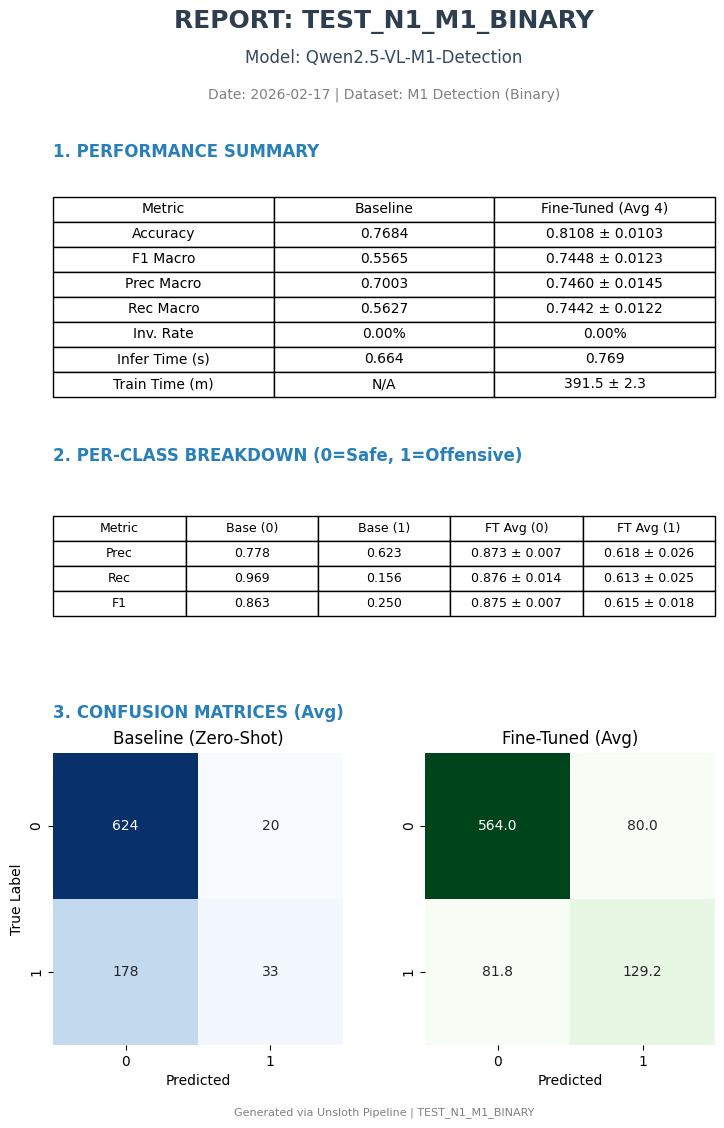

In [14]:
# ==============================================================================
# CELLA 7: REPORT FINALE & PDF GENERATION
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime
import seaborn as sns

# Aggregazione
df = pd.DataFrame([res_base] + ft_results)
ft_df = df[df["model"] == "Fine-Tuned"]

if ft_df.empty:
    print("⚠️ Nessun dato Fine-Tuned disponibile.")
else:
    # Calcolo Medie
    cols_num = ft_df.select_dtypes("number").columns
    ft_mean = ft_df[cols_num].mean()
    ft_std = ft_df[cols_num].std()

    # Nome PDF Dinamico (Include Test ID nel nome file se vuoi, o solo nel path)
    pdf_filename = f"Report_{TEST_ID}_{MODEL_SHORTNAME}.pdf"
    pdf_path = os.path.join(CURRENT_OUTPUT_DIR, pdf_filename)
    
    print(f"\n📄 Generazione PDF: {pdf_path}...")
    
    # Prep Matrici
    ft_cms = np.array([r['conf_matrix'] for r in ft_results])
    avg_ft_cm = np.mean(ft_cms, axis=0)
    base_cm = np.array(res_base['conf_matrix'])

    # Layout A4
    fig = plt.figure(figsize=(8.27, 11.69))
    
    # Header
    plt.figtext(0.5, 0.95, f"REPORT: {TEST_ID}", ha='center', fontsize=18, weight='bold', color='#2c3e50')
    plt.figtext(0.5, 0.92, f"Model: {MODEL_SHORTNAME}", ha='center', fontsize=12, color='#34495e')
    plt.figtext(0.5, 0.89, f"Date: {datetime.now().strftime('%Y-%m-%d')} | Dataset: M1 Detection (Binary)", ha='center', fontsize=10, color='gray')

    # 1. Overall Table
    plt.figtext(0.1, 0.84, "1. PERFORMANCE SUMMARY", fontsize=12, weight='bold', color='#2980b9')
    t1_data = [
        ["Metric", "Baseline", f"Fine-Tuned (Avg {len(ft_results)})"],
        ["Accuracy", f"{res_base['accuracy']:.4f}", f"{ft_mean['accuracy']:.4f} ± {ft_std['accuracy']:.4f}"],
        ["F1 Macro", f"{res_base['f1_macro']:.4f}", f"{ft_mean['f1_macro']:.4f} ± {ft_std['f1_macro']:.4f}"],
        ["Prec Macro", f"{res_base['precision_macro']:.4f}", f"{ft_mean['precision_macro']:.4f} ± {ft_std['precision_macro']:.4f}"],
        ["Rec Macro", f"{res_base['recall_macro']:.4f}", f"{ft_mean['recall_macro']:.4f} ± {ft_std['recall_macro']:.4f}"],
        ["Inv. Rate", f"{res_base['invalid_rate']:.2%}", f"{ft_mean['invalid_rate']:.2%}"],
        ["Infer Time (s)", f"{res_base['avg_inference_time_sec']:.3f}", f"{ft_mean['avg_inference_time_sec']:.3f}"],
        ["Train Time (m)", "N/A", f"{ft_mean['train_time']:.1f} ± {ft_std['train_time']:.1f}"]
    ]
    ax1 = plt.axes([0.1, 0.63, 0.8, 0.18])
    ax1.axis('off')
    tab1 = ax1.table(cellText=t1_data, loc='center', cellLoc='center', colLabels=None)
    tab1.auto_set_font_size(False); tab1.set_fontsize(10); tab1.scale(1, 1.5)
    
    # 2. Per-Class Table
    plt.figtext(0.1, 0.58, "2. PER-CLASS BREAKDOWN (0=Safe, 1=Offensive)", fontsize=12, weight='bold', color='#2980b9')
    t2_data = [["Metric", "Base (0)", "Base (1)", "FT Avg (0)", "FT Avg (1)"]]
    for m, s in [("Prec", "_p"), ("Rec", "_r"), ("F1", "_f1")]:
        row = [m]
        row.append(f"{res_base['class_0'+s]:.3f}")
        row.append(f"{res_base['class_1'+s]:.3f}")
        row.append(f"{ft_mean['class_0'+s]:.3f} ± {ft_std['class_0'+s]:.3f}")
        row.append(f"{ft_mean['class_1'+s]:.3f} ± {ft_std['class_1'+s]:.3f}")
        t2_data.append(row)
        
    ax2 = plt.axes([0.1, 0.43, 0.8, 0.12])
    ax2.axis('off')
    tab2 = ax2.table(cellText=t2_data, loc='center', cellLoc='center')
    tab2.auto_set_font_size(False); tab2.set_fontsize(9); tab2.scale(1, 1.5)

    # 3. Confusion Matrices
    plt.figtext(0.1, 0.36, "3. CONFUSION MATRICES (Avg)", fontsize=12, weight='bold', color='#2980b9')
    
    ax3 = plt.axes([0.1, 0.08, 0.35, 0.25])
    sns.heatmap(base_cm, annot=True, fmt='d', cmap='Blues', ax=ax3, cbar=False, xticklabels=TARGET_CLASSES, yticklabels=TARGET_CLASSES)
    ax3.set_title("Baseline (Zero-Shot)")
    ax3.set_ylabel("True Label"); ax3.set_xlabel("Predicted")
    
    ax4 = plt.axes([0.55, 0.08, 0.35, 0.25])
    sns.heatmap(avg_ft_cm, annot=True, fmt='.1f', cmap='Greens', ax=ax4, cbar=False, xticklabels=TARGET_CLASSES, yticklabels=TARGET_CLASSES)
    ax4.set_title("Fine-Tuned (Avg)")
    ax4.set_xlabel("Predicted")

    # Footer
    plt.figtext(0.5, 0.02, f"Generated via Unsloth Pipeline | {TEST_ID}", ha='center', fontsize=8, color='gray')

    with PdfPages(pdf_path) as pdf:
        pdf.savefig(fig)
    print(f"✅ Report PDF salvato in: {pdf_path}")